## Step 1: Original Inference Process

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os

torch.hub.set_dir('./torch/hub')
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

# Load the ImageNet class index mapping
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = './imagenet_samples'

# List of image file paths
image_paths = os.listdir(imagenet_path)


for img_path in image_paths:
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    print(f"Predicted label: {predicted_synset} ({predicted_label})")

/home/ajifang/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ajifang/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted label: n03938244 (pillow)
Predicted label: n04118776 (rule)
Predicted label: n01806143 (peacock)
Predicted label: n03250847 (drumstick)
Predicted label: n03792782 (mountain_bike)


## Step 2: Perturbation Helper Functions

In [3]:
import numpy as np
from skimage.segmentation import slic

def perturb_image(image: np.array, num_samples: int):
    perturbations, masks = list(), list()
    
    num_segments = int(num_samples / 20)
    segments = slic(image, n_segments=num_segments, start_label=0)
    
    for _ in range(num_samples):
        mask = np.random.randint(0, 2, num_segments)
        perturbation = image.copy()
        for seg_idx in range(num_segments):
            if mask[seg_idx] == 0:
                perturbation[segments==seg_idx] = 0
        perturbations.append(perturbation)
        masks.append(mask)
    
    return perturbations, masks, segments
    
def preprocess_images(images, preprocess) -> torch.tensor:
    outputs = list()
    for image in images:
        image = Image.fromarray(image)
        image = preprocess(image)
        outputs.append(image.unsqueeze(0))
    return torch.cat(outputs, dim=0)
    

## Step 3: LIME Explanation

In [3]:
from sklearn.linear_model import LinearRegression

def LIME(image, model, preprocess, original_label, num_samples=1000, device='cuda'):
    model.to(device)
    pert_images, pert_masks, segments = perturb_image(image, num_samples)
    pert_images = preprocess_images(pert_images, preprocess)
    # print('pert_images.shape', pert_images.shape)
    
    pert_images = pert_images.to(device)
    with torch.no_grad():
        yhat = model(pert_images)
        probabilities = torch.softmax(
            yhat, dim=1
        )[:, original_label].cpu().numpy()
    
    linear_model = LinearRegression()
    linear_model.fit(pert_masks, probabilities)
    segment_importance = linear_model.coef_ # dim=num_segments
    
    importance_map = np.zeros_like(image, dtype=np.float32)
    for seg_idx in range(segment_importance.size):
        importance_map[segments==seg_idx] = segment_importance[seg_idx]
    return importance_map

In [4]:
def image_regularization(image: np.array, alpha=0.5):
    normalized_map = (image - image.min()) / (image.max() - image.min() + 1e-8)
    enhanced_map = normalized_map ** alpha
    return enhanced_map

Predicted label: n03938244 (pillow)
(375, 500, 3)


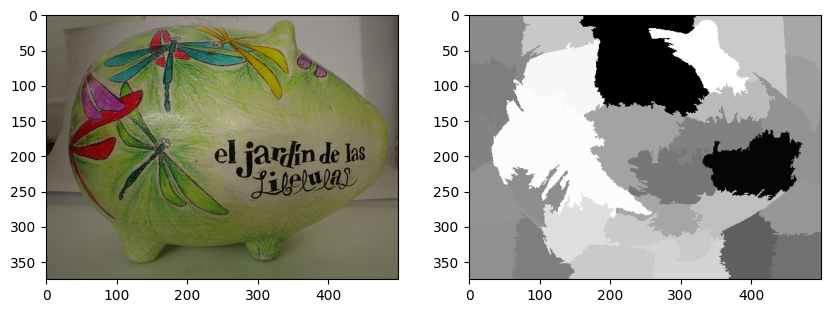

Predicted label: n04118776 (rule)
(366, 630, 3)


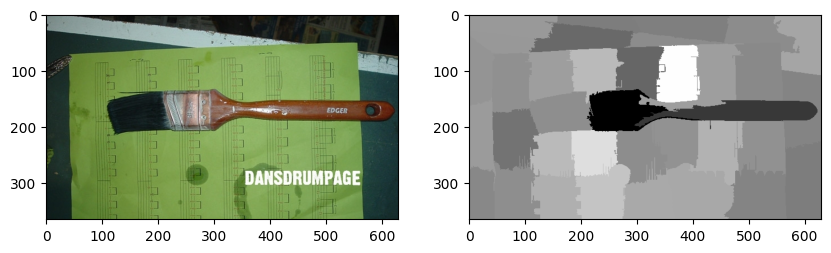

Predicted label: n01806143 (peacock)
(375, 500, 3)


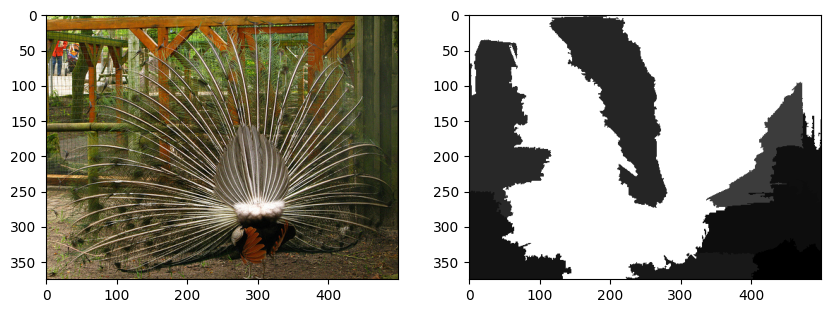

Predicted label: n03250847 (drumstick)
(361, 500, 3)


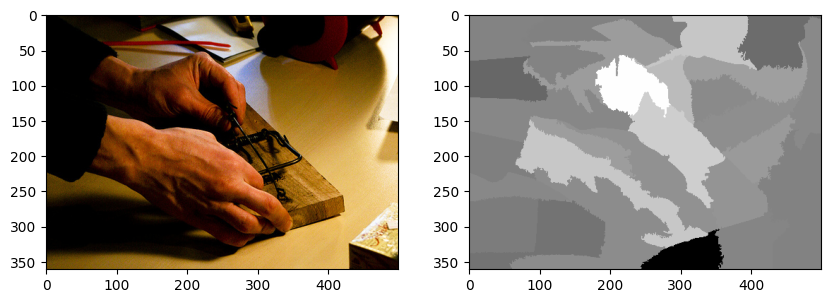

Predicted label: n03792782 (mountain_bike)
(333, 500, 3)


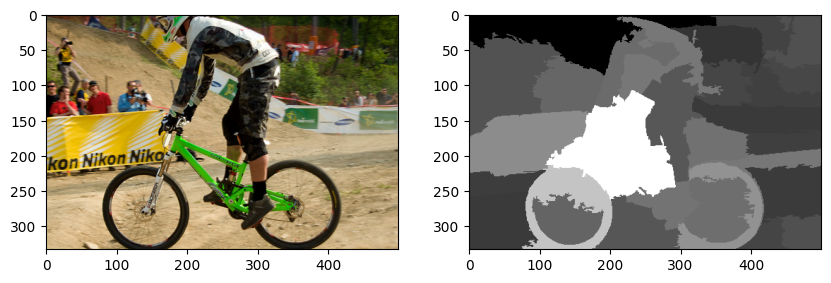

In [13]:
from matplotlib import pyplot as plt
import json

res = {}
for img_path in image_paths:
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        # print('Expected shape:', input_batch.shape)
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    print(f"Predicted label: {predicted_synset} ({predicted_label})")
    
    image = np.array(input_image)
    importance_map = LIME(image, model, preprocess, predicted_idx)
    assert np.max(importance_map) != np.min(importance_map)
    importance_map = image_regularization(importance_map)
    print(importance_map.shape)
    res[img_path] = importance_map.tolist()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(importance_map, cmap='hot')
    plt.show()

with open('LIME.json', 'w') as f:
    json.dump(res, f, indent='  ')

## Step 4: SmoothGrad Explanation

In [5]:
import copy

def SmoothGrad(image, model, preprocess, original_label, num_samples=300, device='cuda'):
    model = copy.deepcopy(model)
    model.eval()
    model = model.to(device)
    pert_images, pert_masks, segments = perturb_image(image, num_samples)
    pert_images = preprocess_images(pert_images, preprocess)
    pert_images = pert_images.to(device)
    pert_images = pert_images.requires_grad_(True)
    
    print('pert_images.shape', pert_images.shape)
    
    yhat = model(pert_images)
    logit = torch.mean(yhat[:, original_label])
    # print('logit:', logit)
    # print('pert_images', pert_images)
    logit.backward()
    
    M_c_x_hat = pert_images.grad
    M_c_x_hat = torch.abs(torch.mean(torch.mean(M_c_x_hat, dim=0), dim=0))
    return M_c_x_hat.cpu().numpy()
    

Predicted label: n03938244 (pillow)


pert_images.shape torch.Size([300, 3, 224, 224])


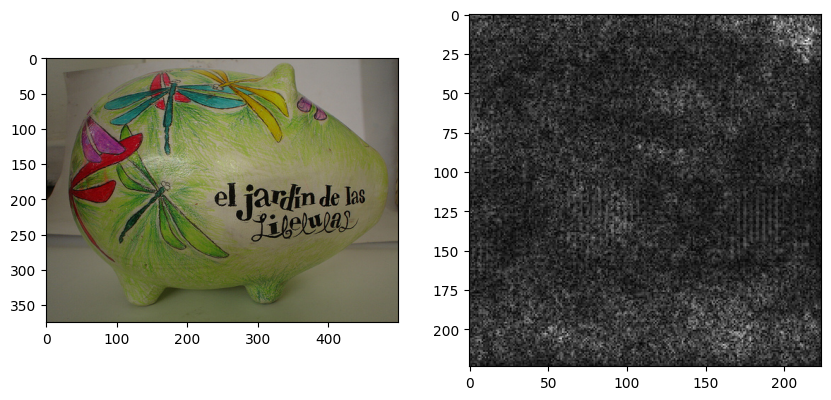

Predicted label: n04118776 (rule)
pert_images.shape torch.Size([300, 3, 224, 224])


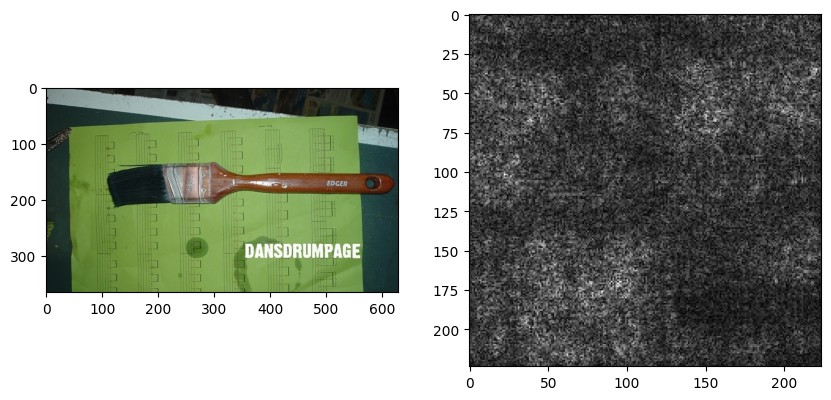

Predicted label: n01806143 (peacock)
pert_images.shape torch.Size([300, 3, 224, 224])


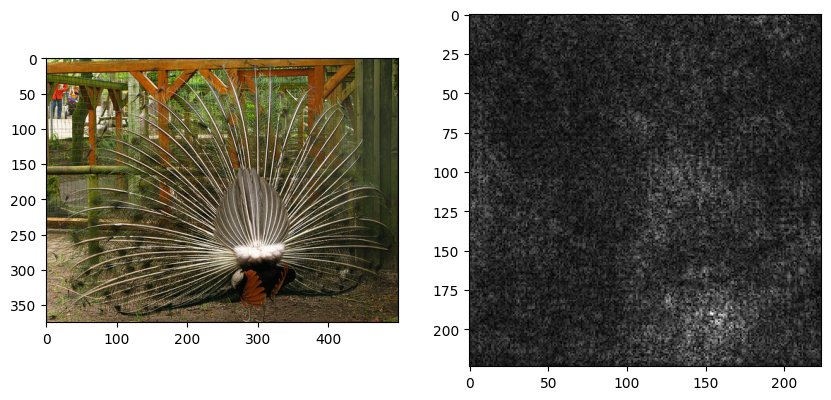

Predicted label: n03250847 (drumstick)
pert_images.shape torch.Size([300, 3, 224, 224])


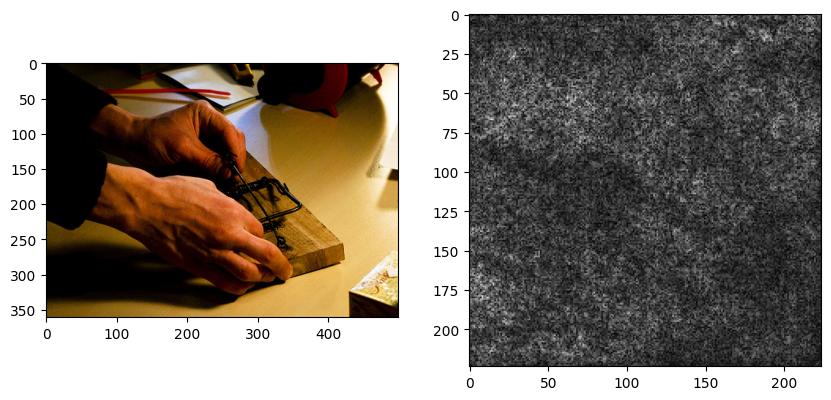

Predicted label: n03792782 (mountain_bike)
pert_images.shape torch.Size([300, 3, 224, 224])


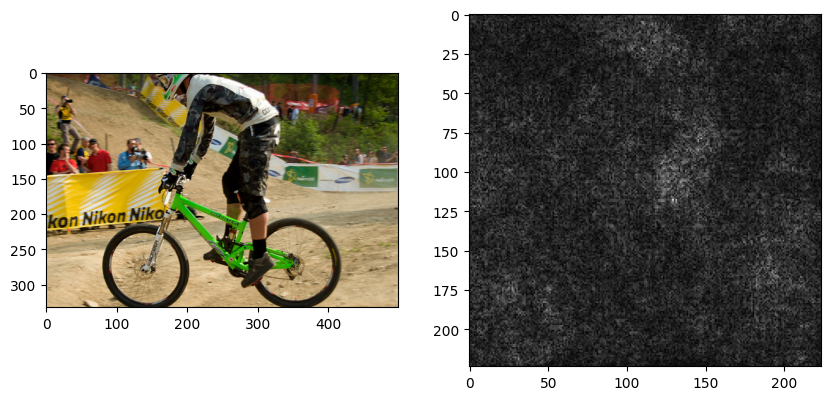

In [9]:

from matplotlib import pyplot as plt
import json

res = {}
for img_path in image_paths:
    torch.cuda.empty_cache()
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        # print('Expected shape:', input_batch.shape)
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    print(f"Predicted label: {predicted_synset} ({predicted_label})")
    
    image = np.array(input_image)
    importance_map = SmoothGrad(image, model, preprocess, predicted_idx)
    assert np.max(importance_map) != np.min(importance_map)
    importance_map = image_regularization(importance_map)
    # print(importance_map.shape)
    # print(np.max(importance_map), np.min(importance_map), np.mean(importance_map))
    res[img_path] = importance_map.tolist()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(importance_map, cmap='gray')
    plt.show()

with open('SoftGrad.json', 'w') as f:
    json.dump(res, f, indent='  ')

## Step 5: Comparison

In [15]:
import numpy as np
import json
from PIL import Image
from scipy.stats import kendalltau, spearmanr

postprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

with open('LIME.json') as f:
    lime = json.load(f)
with open('SoftGrad.json') as f:
    softgrad = json.load(f)
    
for img_path in image_paths:
    el = torch.tensor(lime[img_path])[:, :, 0].numpy()
    el = Image.fromarray(el)
    el = postprocess(el).numpy()
    # print(el.shape)
    es = np.array(softgrad[img_path])
    # print(es.shape)
    
    el = el.flatten()
    es = es.flatten()
    
    ken = kendalltau(el, es)
    spe = spearmanr(el, es)
    print(img_path, '\n', 
          'Kendall-Tau:', ken, '\n',
          'Spearman Rank:', spe, '\n--------------------------------')

piggy_bank.JPEG 
 Kendall-Tau: SignificanceResult(statistic=np.float64(0.047597371594370656), pvalue=np.float64(1.4332186479083144e-54)) 
 Spearman Rank: SignificanceResult(statistic=np.float64(0.07024959921960995), pvalue=np.float64(6.347540423232519e-56)) 
--------------------------------
paintbrush.JPEG 
 Kendall-Tau: SignificanceResult(statistic=np.float64(0.08511336587538076), pvalue=np.float64(5.262184155501874e-172)) 
 Spearman Rank: SignificanceResult(statistic=np.float64(0.1258849477363746), pvalue=np.float64(2.5878055851334518e-176)) 
--------------------------------
peacock.JPEG 
 Kendall-Tau: SignificanceResult(statistic=np.float64(-0.0349184385063749), pvalue=np.float64(1.1599122018752485e-23)) 
 Spearman Rank: SignificanceResult(statistic=np.float64(-0.04476199557190025), pvalue=np.float64(1.1085935456343971e-23)) 
--------------------------------
mousetrap.JPEG 
 Kendall-Tau: SignificanceResult(statistic=np.float64(-0.0033443833387860364), pvalue=np.float64(0.27132068242

## Step 6: PGD Attack

In [1]:
class PGD_optimizer():
    # ref: https://www.geeksforgeeks.org/custom-optimizers-in-pytorch/
    def __init__(self, params, original_params, epsilon, lr=1e-2):
        self.params = list(params)
        self.original_params = original_params
        self.epsilon = epsilon
        self.lr = lr
                
    def step(self):
        with torch.no_grad():
            for param in self.params:
                if param.grad is not None:
                    if torch.max(torch.abs(param.grad.data)) == 0:
                        print("warning: all gradients are 0")
                    param.data = param.data - self.lr * param.grad.data
                else:
                    print("warning: param.grad is None")
                param.data = torch.clamp(
                    param.data, 
                    min = (self.original_params.data - self.epsilon), 
                    max = (self.original_params.data + self.epsilon)
                )
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [6]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 5

def pgd_attack(epsilon, images, labels, original_importance_map):
    print(f'epsilon: {epsilon}')
    
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images_original = images.clone().detach()
    criterion_reg = nn.CrossEntropyLoss()
    criterion_attack = nn.MSELoss()
    
    for epoch in range(num_epochs):
        optimizer = PGD_optimizer([images], images_original, epsilon)
        images.requires_grad = True
        optimizer.zero_grad()
        yhat = model(images)
        importance_map = SmoothGrad(images, model, preprocess, labels)
        loss_reg = criterion_reg(yhat, labels)
        loss_attack = -criterion_attack(importance_map, original_importance_map)
        loss = loss_reg + loss_attack
        # print(epoch, loss.item())
        loss.backward()
        # print(images.grad.data)
        optimizer.step()
        images = images.detach().clone()
    
    assert torch.max(torch.abs(images_original - images)) != 0
    assert torch.max(torch.abs(images_original - images)) <= 1.1 * epsilon
    
    print("#####", torch.max(model(images), 1)[1], "#####")
    return images

In [ ]:
with open('SoftGrad.json') as f:
    softgrad = json.load(f)

for img_path in image_paths:
    torch.cuda.empty_cache()
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        # print('Expected shape:', input_batch.shape)
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    
    
    